In [3]:
!pip install PyWavelets

## 以下是使用MODWT-WRA进行股票溢价预测的一般步骤：

数据准备：首先，收集相关的股票溢价数据和其他可能的影响因素数据，比如股票指数、宏观经济数据等。确保数据具有足够的时间跨度和频率。

MODWT分解：使用MODWT方法对股票溢价数据进行多尺度分解。MODWT可以将时间序列分解成低频和高频成分，并揭示时间序列在不同尺度上的变化模式。

分析低频成分：通过分析低频成分，可以获取关于长期趋势和周期性的信息，以及可能存在的潜在长期关系。

分析高频成分：通过分析高频成分，可以获取关于短期波动和噪音的信息，找出短期价格的异常变动和不规则模式。

重构和预测：使用Wavelet-Based Reconstructive Approximation（WRA）方法将分解后的成分重构回原始序列，从而得到预测的股票溢价值。

当调用 pywt.swt(prices, wavelet) 对数据进行小波变换时，确保数据的长度为偶数。

## 此处我们针对BCOMTR指数来计算

### 先做数据处理，选择一个指数并进行异常值处理

In [11]:
import numpy as np
import pandas as pd
import pywt

# 读取股票数据
df= pd.read_csv("Datasets2.csv",header=1)  # 将文件路径替换成实际的数据文件路径

In [12]:
df.head()

,Dates,PX_LAST,PX_LAST.1,PX_LAST.2,PX_LAST.3,PX_LAST.4,PX_LAST.5,PX_LAST.6,PX_LAST.7,PX_LAST.8,...,PX_LAST.44,PX_LAST.45,PX_LAST.46,PX_LAST.47,PX_LAST.48,PX_LAST.49,PX_LAST.50,PX_LAST.51,PX_LAST.52,PX_LAST.53
0,#NAME?,143.423,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,...,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?
1,1996/6/7,145.107,3177.601,662.25,232.4962,393.6207,1589.469,4809.132,NaN,NaN,...,326.03,NaN,239.68,1156.17,498.2,602.71,191.75,489.81,1317.29,673.31
2,1996/6/10,146.233,3177.601,661.52,232.4962,393.6207,1589.469,4809.132,NaN,NaN,...,325.6,NaN,240.08,1157.52,496.95,602.18,191.73,490.19,1317.29,672.16
3,1996/6/11,144.812,3177.601,660.99,232.4962,393.6207,1589.469,4809.132,NaN,NaN,...,325.09,NaN,240.4,1160.05,493.74,600.57,191.74,490.86,1317.29,670.97
4,1996/6/12,144.748,3177.601,660.06,232.4962,393.6207,1589.469,4809.132,NaN,NaN,...,324.1,NaN,241.29,1166.08,494.38,598.42,192.1,493.35,1317.29,669.04


In [14]:
data=df[['Dates','PX_LAST']]
# 删除值为 "#NAME?" 的行
data = data[data != '#NAME?'].dropna()
data = data.reset_index(drop=True)
data

,Dates,PX_LAST
0,1996/6/7,145.1070
1,1996/6/10,146.2330
2,1996/6/11,144.8120
3,1996/6/12,144.7480
4,1996/6/13,144.5230
...,...,...
7060,2023/6/30,226.7436
7061,2023/7/3,226.3374
7062,2023/7/4,226.3374
7063,2023/7/5,228.1342


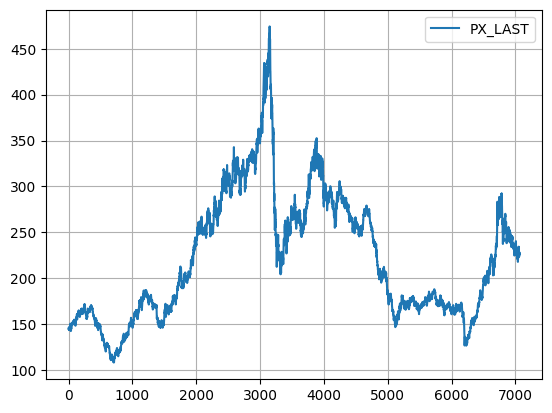

In [22]:
data.plot()
plt.grid()

### 计算溢价

In [3]:
# 当前BCOMTR指数的水平
current_price = data['PX_LAST']

# 假设BCOMTR指数的预期收益率为5%
expected_return = 0.05

# 计算BCOMTR指数的内在价值
intrinsic_value = current_price / (1 + expected_return)

# 计算溢价
premium = current_price - intrinsic_value

# 打印溢价
print("BCOMTR指数的溢价：", premium)


BCOMTR指数的溢价： 0        6.909857
1        6.963476
2        6.895810
3        6.892762
4        6.882048
          ...    
7059    10.665138
7060    10.797314
7061    10.777971
7062    10.777971
7063    10.863533
Name: PX_LAST, Length: 7064, dtype: float64


In [4]:
pr=pd.DataFrame(premium)

In [5]:
pr

,PX_LAST
0,6.909857
1,6.963476
2,6.895810
3,6.892762
4,6.882048
...,...
7059,10.665138
7060,10.797314
7061,10.777971
7062,10.777971


# 用MODWT-WRA进行股票溢价预测

In [6]:
#prices = np.array(data['PX_LAST'].values)
# prices = data['PX_LAST'].values
prices = pr['PX_LAST'].values

# 进行多层小波分解
wavelet = pywt.Wavelet("db4")  # 使用Daubechies 4阶小波
level = 2  # 定义多层分解的层数

coeffs = pywt.wavedec(prices, wavelet, level=level)

# 预测近似系数和细节系数
pred_steps = 5  # 设置预测的时间步长

pred_coeffs = []
for coeff in coeffs:
    padded_coeff = np.pad(coeff, (0, pred_steps), mode='constant')
    pred_coeff = padded_coeff[:len(coeff)]
    pred_coeffs.append(pred_coeff)

# 使用小波重构预测的未来股票溢价
pred_prices = pywt.waverec(pred_coeffs, wavelet)

# 打印预测的未来股票溢价
print("预测的未来股票溢价：")
print(pred_prices[-pred_steps:])

预测的未来股票溢价：
[10.6651381  10.79731429 10.77797143 10.77797143 10.86353333]


In [7]:
dd=[7064,7065,7066,7067,7068]
prediction=[10.6651381 ,10.79731429,10.77797143, 10.77797143, 10.86353333]

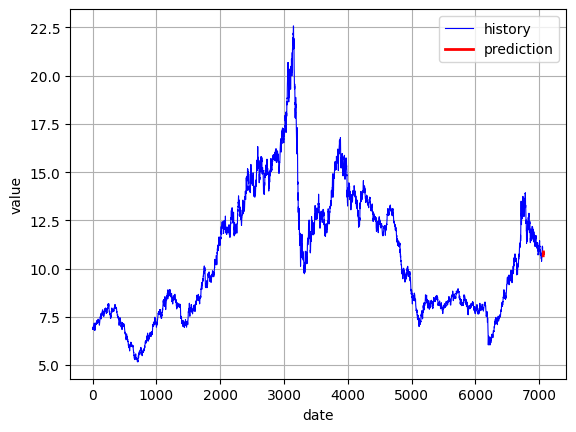

In [24]:
import matplotlib.pyplot as plt

# 绘制历史数据
plt.plot(pr, color='b', label='history',linewidth=0.8)

# 绘制预测数据
plt.plot(dd, prediction, color='red', label='prediction',linewidth=2)

# 添加图例
plt.legend()
plt.grid()
# 添加标题和轴标签
plt.xlabel('date')
plt.ylabel('value')

# 显示图形
plt.show()
